In [ ]:
import os, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split
import sklearn.metrics as sm

# Data Import

In [ ]:
data_list = pd.read_csv('/content/Data_Entry_2017.csv')

In [ ]:
data_list.head()

In [ ]:
data_list = data_list.iloc[:, [0,1]]

In [ ]:
data_list.describe()

,Image Index,Finding Labels
count,86531,86531
unique,86531,9
top,00025063_000.png,No Finding
freq,1,60361


# EDA

In [ ]:
counts = data_list.groupby(['Finding Labels']).agg({'Image Index':'count'})
counts.sort_values('Image Index', ascending=False, inplace=True)

In [ ]:
counts = data_list['Finding Labels'].value_counts()[:10]
counts.sort_values(ascending=True, inplace=True)
counts

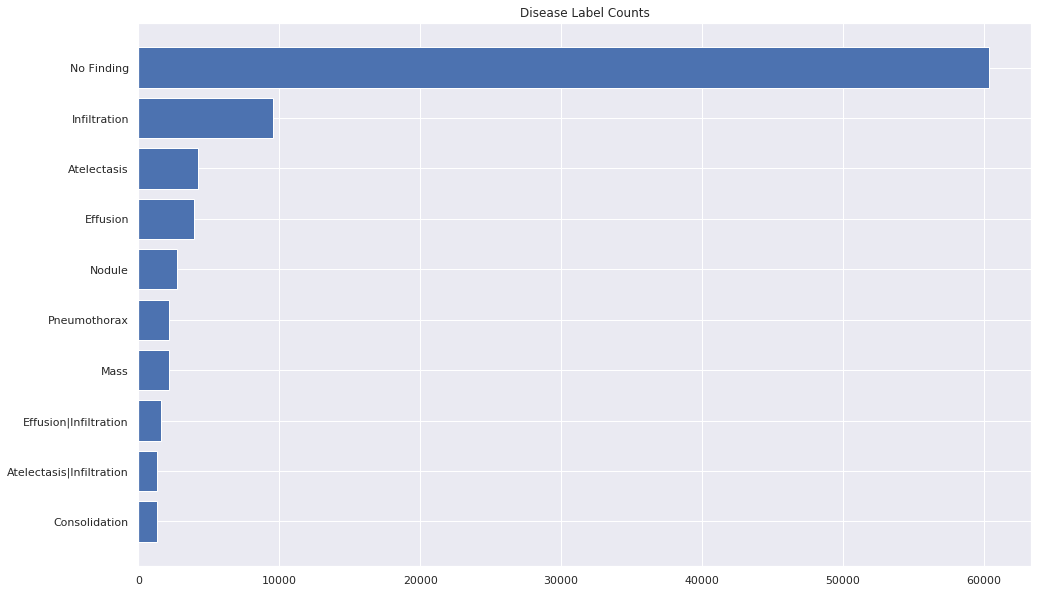

In [ ]:
plt.figure(figsize=(16,10))
plt.barh(y=counts.index, width=counts.values)
plt.title('Disease Label Counts')
plt.show()

# Data Segregation

In [ ]:
disease_list = data_list[data_list['Finding Labels'] != 'No Finding']
Nodisease_list = data_list[data_list['Finding Labels'] == 'No Finding'].sample(2000, random_state=0)

In [ ]:
data_list = pd.concat([disease_list, Nodisease_list], axis=0)
data_list.sort_index(inplace=True)

In [ ]:
len(data_list)

28170

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_list['Image Index'], data_list['Finding Labels'], 
                                                    test_size=0.05, random_state=0, stratify=data_list['Finding Labels'])

In [ ]:
data_train = pd.concat([X_train, y_train], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)

**Segregating Data**

In [ ]:
original_dataset_dir = '/home/rajat/Documents/Aegis/CAPSTONE/Data - CXR8/Data/images'

base_dir = '/home/rajat/Documents/Aegis/CAPSTONE/Data - CXR8/Data/images_small'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

In [ ]:
for i in counts.index:
    os.mkdir(os.path.join(train_dir, i))
    for fname in data_train[data_train['Finding Labels'] == i]['Image Index']:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(train_dir+'/'+i, fname)
        shutil.copyfile(src, dst)

In [ ]:
for i in counts.index:
    os.mkdir(os.path.join(validation_dir, i))
    for fname in data_test[data_test['Finding Labels'] == i]['Image Index']:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(validation_dir+'/'+i, fname)
        shutil.copyfile(src, dst)

# Loading Data in Colab

In [ ]:
# Download the 56 zip files in Images_png in batches
import urllib.request, urllib.parse, urllib.error

# URLs for the zip files
links = [
    'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
    'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
    'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
	'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
    'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
	'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
	'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
    'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
	'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
	'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
	'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
	'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
]

for idx, link in enumerate(links):
    fn = 'images_%02d.tar.gz' % (idx+1)
    print('downloading', fn, '...')
    urllib.request.urlretrieve(link, fn)  # download the zip file
print("Download complete.")

downloading images_01.tar.gz ...
downloading images_02.tar.gz ...
downloading images_03.tar.gz ...
downloading images_04.tar.gz ...
downloading images_05.tar.gz ...
downloading images_06.tar.gz ...
downloading images_07.tar.gz ...
downloading images_08.tar.gz ...
downloading images_09.tar.gz ...


In [ ]:
import tarfile

nums = ['01','02','03','04','05','06','07','08','09','10','11','12']
file_names = ['images_{}.tar.gz'.format(x) for x in nums]

for idx, file in enumerate(file_names):
    with tarfile.open(file, 'r:gz') as tar: 
        print(idx,': Extracting all the files now...') 
        tar.extractall() 
        print(idx,': Done!') 

# Data Preprocessing

In [5]:
import os, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split
import sklearn.metrics as sm

import cv2
from keras.preprocessing import image
from keras import models
from keras import layers
from keras import optimizers
from keras import backend as K

Using TensorFlow backend.


**Initializing data and image directories**

In [ ]:
data = pd.read_csv('/content/Data_Entry_2017.csv')

df_dir = '/content/'
img_dir = '/content/images/'

**Defining functions for data preprocessing and segregation**

In [ ]:
def data_preprocess(data):
    
    def unknown(x):
        
        if 'Infiltration' in x.split('|') or x == 'Infiltration':
            return 'Infiltration'
        elif x == 'No Finding':
            return 'No Finding'
        else:
            return 'Unknown'
    
    data = data.loc[:,['Image Index','Finding Labels']]
    
    data['Finding Labels'] = data['Finding Labels'].apply(unknown)

    data = data[data['Finding Labels'] != 'Unknown']
    data.rename(columns={'Image Index':'images','Finding Labels':'labels'}, 
                inplace=True)
    
    return data

In [ ]:
def get_path(img_name, dir):
    return [dir+x for x in img_name]

In [ ]:
def data_segregation(data):
    data = data_preprocess(data)
    
    data['path'] = get_path(data['images'], img_dir)
    
    data, data_test = train_test_split(data, test_size=0.1, random_state=0)
    
    return data, data_test

In [ ]:
data2, data_test = data_segregation(data)

**Function for listing positive counts of each class**

In [ ]:
def pos_counts(data):
    dis_dict = {}
    labels = data.labels.value_counts()
    for id, i in enumerate(labels.index):
        dis_dict[i] = labels.values[id]
        
    return dis_dict

In [12]:
dis_dict = pos_counts(data2)
dis_dict

{'Infiltration': 17893, 'No Finding': 54336}

In [ ]:
cats_list = list(dis_dict.keys())

**Plotting label counts**

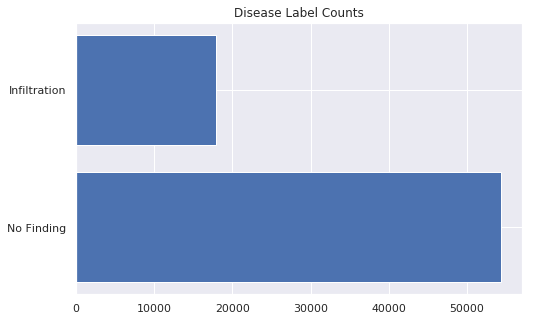

In [ ]:
plt.figure(figsize=(8,5))
plt.barh(y=list(dis_dict.keys()), 
         width=list(dis_dict.values()))
plt.title('Disease Label Counts')
plt.show()

**Data Augmentation**

In [ ]:
shutil.rmtree('aug_images')
os.mkdir('aug_images')

In [ ]:
def data_augment(id, label='Infiltration'):    
    
    print('Generating data for',label)
    num=5000
    df = data2[data2['labels'] == label]
    df_length = len(df)
    
    cnt = 0
    file_name = []
    file_label = []
    file_path = []
    dir = '/content/aug_images/'
        
    img_gen = image.ImageDataGenerator(horizontal_flip=True,
                                       vertical_flip=False,
                                       rotation_range=5,
                                       shear_range=0.1,
                                       fill_mode='reflect',
                                       zoom_range=0.15)
    
    aug_gen = img_gen.flow_from_dataframe(dataframe=df, 
                                     directory=None, 
                                     x_col='path',
                                     y_col='labels',
                                     target_size=(224,224),
                                     color_mode='rgb',
                                     class_mode='input',
                                     batch_size=num, seed=0)

    for i in range(3):
        
        X, Y = next(aug_gen)
        
        for x, y in zip(X, Y):
            img_name = 'a{}_{}.png'.format(id, cnt)
            file_name.append(img_name)
            file_label.append(label)
            file_path.append(dir+img_name)

            image.save_img(dir+img_name, x)
            cnt += 1
        
    aug_df = pd.DataFrame({'images':file_name, 
                           'labels':file_label,
                           'path':file_path})
    print(len(aug_df),'images generated')
    
    return aug_df 

In [ ]:
dfs = [data_augment(id=1)]

In [ ]:
Nodisease_list = data2[data2['labels'] == 'No Finding'].sample(15000, random_state=0)
dfs.append(Nodisease_list)

In [ ]:
data2 = pd.concat(dfs, axis=0)
data2.sort_index(inplace=True)
data2.labels.value_counts()

In [ ]:
for i in cats_list:
    data2[i] = data2['labels'].map(lambda x: 1. if i == x else 0.)
data2.drop('No Finding', axis=1, inplace=True)

**Splitting data into train set and validation set**

In [ ]:
df_train, df_val = train_test_split(data2, test_size = 0.2, random_state = 0)

**Setting image size**

In [ ]:
height = 224
width = 224

**Generating augmented images in batches for training and validation**

In [ ]:
img_gen = image.ImageDataGenerator(rescale=1./255.,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   rotation_range=20,
                                   zoom_range=0.15
                                  )

In [18]:
train_gen = img_gen.flow_from_dataframe(dataframe=df_train, 
                                        directory=None, 
                                        x_col='path',
                                        y_col='labels',
                                        target_size=(height,width),
                                        color_mode='rgb',
                                        class_mode='binary',
                                        batch_size=32, seed=0)

val_gen = img_gen.flow_from_dataframe(dataframe=df_val, 
                                        directory=None, 
                                        x_col='path',
                                        y_col='labels',
                                        target_size=(height,width),
                                        color_mode='rgb',
                                        class_mode='binary',
                                        batch_size=64, seed=0)

Found 57783 images belonging to 2 classes.
Found 14446 images belonging to 2 classes.


# Model Building for Multi-Label Classification

**Calculating class weights**

In [19]:
from sklearn.utils.class_weight import compute_class_weight

uni = data2['labels'].unique()
uni.sort()
weights = list(compute_class_weight('balanced', uni, data2['labels']))
weights

[2.0183591348572065, 0.6646514281507656]

In [ ]:
input_img = models.Input(shape=(224,224,3), name='ImageInput')
x = layers.Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
x = layers.MaxPooling2D((2,2), name='pool1')(x)

x = layers.SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
x = layers.SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
x = layers.MaxPooling2D((2,2), name='pool2')(x)

x = layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
x = layers.BatchNormalization(name='bn1')(x)
x = layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
x = layers.BatchNormalization(name='bn2')(x)
x = layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
x = layers.MaxPooling2D((2,2), name='pool3')(x)

x = layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
x = layers.BatchNormalization(name='bn3')(x)
x = layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
x = layers.BatchNormalization(name='bn4')(x)
x = layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
x = layers.MaxPooling2D((2,2), name='pool4')(x)

x = layers.Flatten(name='flatten')(x)
x = layers.Dense(1024, activation='relu', name='fc1')(x)
x = layers.Dropout(0.7, name='dropout1')(x)
x = layers.Dense(512, activation='relu', name='fc2')(x)
x = layers.Dropout(0.5, name='dropout2')(x)
x = layers.Dense(2, activation='softmax', name='fc3')(x)

model = models.Model(inputs=input_img, outputs=x)

In [ ]:
model.load_weights('best_model.hdf5')

**Freezing the layers in base**

In [ ]:
for i in range(len(model.layers)):
    model.layers[i].trainable = False

**Adding our top layers**

In [ ]:
x = layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(model.layers[-13].output)
x = layers.BatchNormalization(name='bn3')(x)
x = layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
x = layers.BatchNormalization(name='bn4')(x)
x = layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1, activation='sigmoid', name='fc_out')(x)

model = models.Model(inputs=model.input, outputs=x)

In [ ]:
!kaggle datasets download -d keras/vgg16
!unzip vgg16.zip

In [ ]:
import h5py

f = h5py.File('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[7].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[8].set_weights = [w,b]

f.close()

**Loading our saved model to resume training**

In [65]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageInput (InputLayer)         (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_1 (Conv2D)                (None, 224, 224, 64) 1792        ImageInput[0][0]                 
__________________________________________________________________________________________________
activation1_1 (Activation)      (None, 224, 224, 64) 0           Conv1_1[0][0]                    
__________________________________________________________________________________________________
Conv1_2 (Conv2D)                (None, 224, 224, 64) 36928       activation1_1[0][0]              
__________________________________________________________________________________________________
activation

**Initializing callbacks**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
weight_path="best_weights_{val_loss:.4f}.hdf5"

checkpoint = ModelCheckpoint(weight_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             save_weights_only = True)

early_stop = EarlyStopping(monitor="val_loss", 
                           mode="min", 
                           patience=20)

In [ ]:
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[1]**(1-y_true))*(weights[0]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss

In [ ]:
model.compile(optimizer=optimizers.Adam(lr=0.001, decay=1e-5),
              loss=get_weighted_loss(weights),
              metrics=['acc'])

In [ ]:
history = model.fit_generator(train_gen, 
                              steps_per_epoch=len(df_train)/(train_gen.batch_size*4),
                              validation_data=val_gen,
                              validation_steps=len(df_val)/(val_gen.batch_size*4),
                              epochs=3,
                              callbacks=[checkpoint])

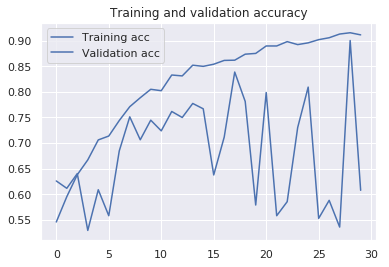

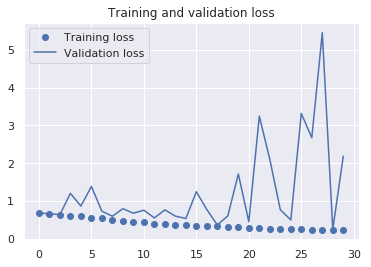

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Model Performance Validation

In [ ]:
model.save('model_latest.h5')

In [31]:
test_gen = img_gen.flow_from_dataframe(dataframe=data_test, 
                                        directory=None, 
                                        x_col='path',
                                        y_col='labels',
                                        target_size=(height,width),
                                        color_mode='rgb',
                                        class_mode='binary',
                                        #classes=cats_list,
                                        batch_size=4096, seed=0)

Found 8026 images belonging to 2 classes.


In [ ]:
X_test, Y_test = next(test_gen)

In [38]:
test_pred_y = model.predict(X_test, batch_size=32, verbose=True)

4096/4096 [==============================] - 19s 5ms/step


Text(0, 0.5, 'True Positive Rate')

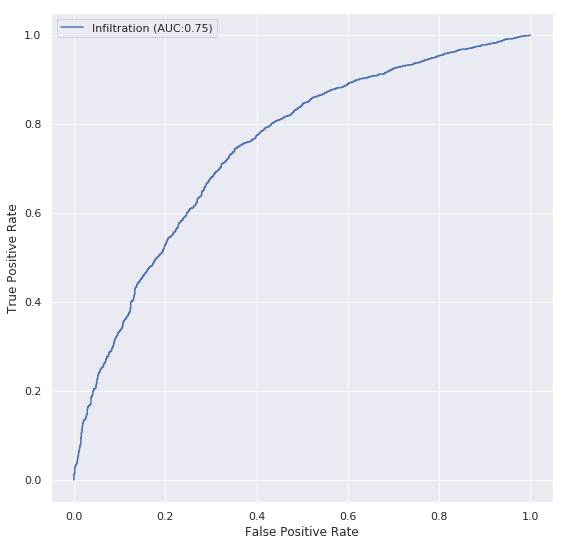

In [39]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))

fpr, tpr, thresholds = roc_curve(Y_test.astype(int), test_pred_y[:,0])
c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Infiltration', auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

# Generating CAMs

In [ ]:
from keras.applications.densenet import preprocess_input
from matplotlib.patches import Rectangle

In [ ]:
bbox_data = pd.read_csv('/content/BBox_List_2017.csv')
bbox_data = bbox_data.loc[:,:'h]']

In [ ]:
bbox_data.rename(columns={'Bbox [x':'x', 
                     'h]':'h',
                     'Image Index':'images',
                     'Finding Label':'labels'}, 
            inplace=True)

In [ ]:
def plot_bbox(img):
    img_path = '/content/images/'+img
    row = bbox_data[bbox_data.images == img]
    plt.figure()
    plt.imshow(cv2.imread(img_path))
    rect = Rectangle((row.x.values[0],row.y.values[0]), 
                     row.w.values[0], row.h.values[0], 
                     fill=False, color='red')
    plt.axes().add_patch(rect)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


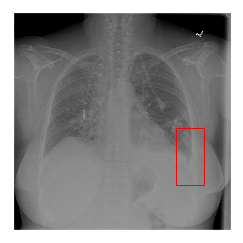

In [69]:
im = '00028640_008.png'
plot_bbox(im)
img_path = '/content/images/'+im

In [70]:
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
preds = list(preds.flatten())
print(preds)
class_idx = np.argmax(preds)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer('activation5_3')

grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(1024):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

[0.6743338]


In [ ]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

img = cv2.imread(img_path,)
img = cv2.resize(img,(256, 256))
heatmap = cv2.resize(heatmap, (256, 256))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

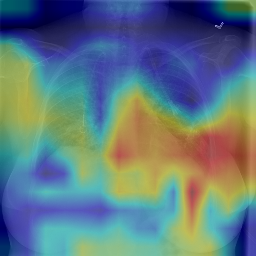

In [72]:
from google.colab.patches import cv2_imshow
cv2_imshow(superimposed_img)